# Gamma Ray Bursts

Let's look at the latest database of Gamma Ray Bursts.

- The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
- You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html

This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. Be creative! You're discovering

Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed?

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [2]:
# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

print(data)
print(data.shape)
print(names)

[['GRB240814C' 'GRB240814A' 'GRB240812D' ... 'GRB910424A*' 'GRB910423A*'
  'GRB910421A*']
 ['None' 'None' 'None' ... 'None' 'None' 'None']
 ['18:50:17' '3:56:12' '22:34:03' ... '19:43:25.064' '19:51:15.804'
  '9:14:03.800']
 ...
 ['-999' '-999' '-999' ... '3.1360' '208.5760' '5.6960']
 ['True' 'True' 'True' ... 'False' 'False' 'False']
 ['60536.78491898' '60536.16402778' '60534.94031250' ... '48370.82181787'
  '48369.82726625' '48367.38476620']]
(15, 8509)
['GRB_name' 'GRB_name_Fermi' 'T0' 'ra' 'decl' 'pos_error' 'T90'
 'T90_error' 'T90_start' 'fluence' 'fluence_error' 'redshift' "'T100'"
 'GBM_located' 'mjd_(T0)']



## Data exploration

Let's have a look at the data:

In [3]:
ra = np.array(data[3], dtype=float)
decl = np.array(data[4], dtype=float)
pos_err = np.array(data[5], dtype=float)
t90_prov = np.array(data[6], dtype=float)
t90_err = np.array(data[7], dtype=float)
fluence_prov = np.array(data[9], dtype=float)
fluence_err = np.array(data[10], dtype=float)
z_prov = np.array(data[11], dtype=float)

t90_mask = t90_prov > 0
t90 = t90_prov[t90_mask]

fluence_mask = fluence_prov > 0
fluence = fluence_prov[fluence_mask]

z_mask = z_prov > 0
z = z_prov[z_mask]

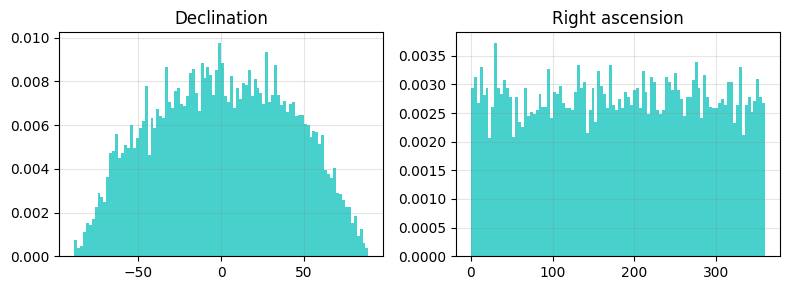

In [4]:
# Declination and right ascension
fig, ax = plt.subplots(1, 2, figsize=(8, 3))

ax[0].hist(decl, bins=100, density=True, color='mediumturquoise')
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_title('Declination')

ax[1].hist(ra, bins=100, density=True, color='mediumturquoise')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_title('Right ascension')

plt.tight_layout()
plt.show()

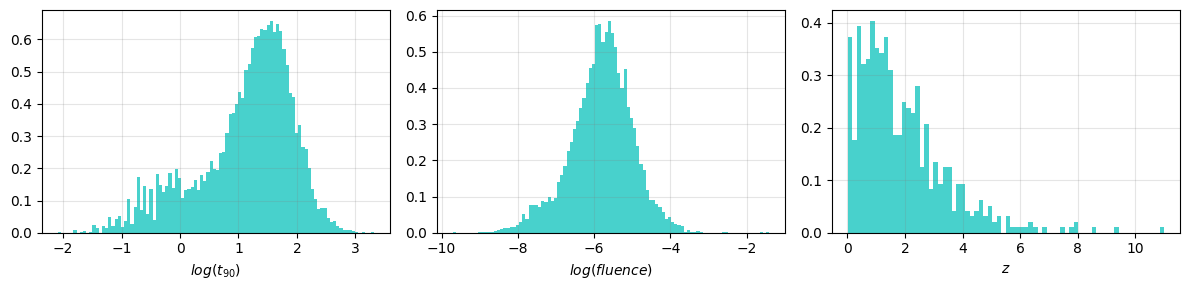

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

logt90 = np.log10(t90)
logfluence = np.log10(fluence)

ax[0].hist(logt90, bins=100, density=True, color='mediumturquoise')
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_xlabel('$log(t_{90})$')

ax[1].hist(logfluence, bins=100, density=True, color='mediumturquoise')
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_xlabel('$log(fluence)$')

ax[2].hist(z, bins=70, density=True, color='mediumturquoise')
ax[2].grid(c='grey', alpha = 0.2)
ax[2].set_xlabel('$z$')

plt.tight_layout()
plt.show()

There seems to be a bimodality in the $log(t_{90})$ distribution. Let's start from it.

## $t_{90}$


In [6]:
print(t90_prov.shape)
print(t90.shape)

(8509,)
(7428,)


We can start by fitting a KDE to the data:

### KDE


In [7]:
def kde_sklearn(data, bandwidth, kernel, xgrid):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(np.log10(xgrid)[:, np.newaxis])

    return np.exp(log_pdf)

In [8]:
bwrange = np.linspace(0.01,0.2, 10) # Testing 10 bandwidths from 0.01 to 0.2 with a 5-fold cross validation
print(bwrange)

n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=336)

grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= kf) 
grid.fit(logt90[:, np.newaxis])
band_opt = grid.best_params_['bandwidth']
print('Optimal bandwidth: %.2f' % band_opt)

[0.01       0.03111111 0.05222222 0.07333333 0.09444444 0.11555556
 0.13666667 0.15777778 0.17888889 0.2       ]
Optimal bandwidth: 0.12


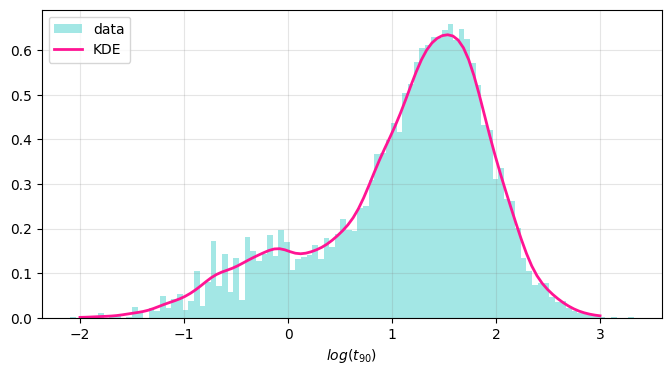

In [9]:
xgrid=np.logspace(-2,3,100)

plt.figure(figsize=(8, 4))
pdf = kde_sklearn(logt90, bandwidth = band_opt, kernel='gaussian', xgrid=xgrid)
plt.hist(logt90, bins=100, density=True, color='mediumturquoise', alpha = 0.5, label = 'data')
plt.plot(np.log10(xgrid), pdf, c='deeppink', lw= 2, label = 'KDE')
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$log(t_{90})$')
plt.legend(loc='upper left')
plt.show()

This KDE confirms that the distribution is (at least) bimodal. We can also check with a gaussian mixture to search for the number of gaussians that best represents the data.

### Gaussian Mixture

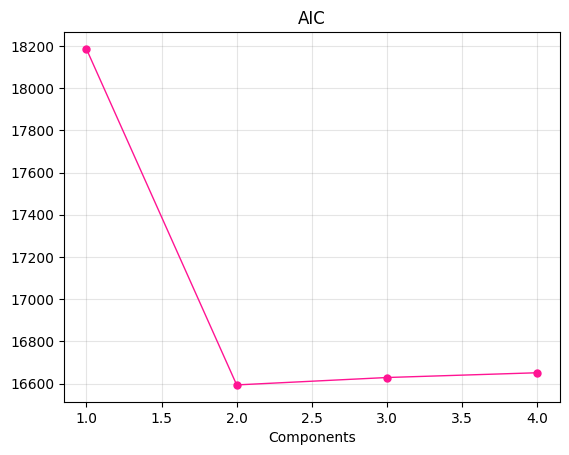

Optimal number of components according to AIC: 2
Optimal number of components through cross validation: 2


In [10]:
components = np.array([1, 2, 3, 4])     # I don't think there are more than 4 components

# Using AIC
gm = np.array([GaussianMixture(n_components=n).fit(logt90[:,np.newaxis]) for n in components])
AIC = np.empty(len(components))

for i, n in enumerate(components):
    AIC[i] = gm[i].aic(logt90[:, np.newaxis])

plt.plot(components, AIC, c = 'deeppink', markersize = 5, marker = 'o', linewidth = 1)
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('Components')
plt.title('AIC')
plt.show()

print('Optimal number of components according to AIC: %i' % components[np.argmin(AIC)]) 
best_model = gm[np.argmin(AIC)]

# Using cross validation
grid = GridSearchCV(GaussianMixture(), {'n_components': components}, cv= kf) 
grid.fit(logt90[:, np.newaxis])
n_opt = grid.best_params_['n_components']
print('Optimal number of components through cross validation: %i' % n_opt)

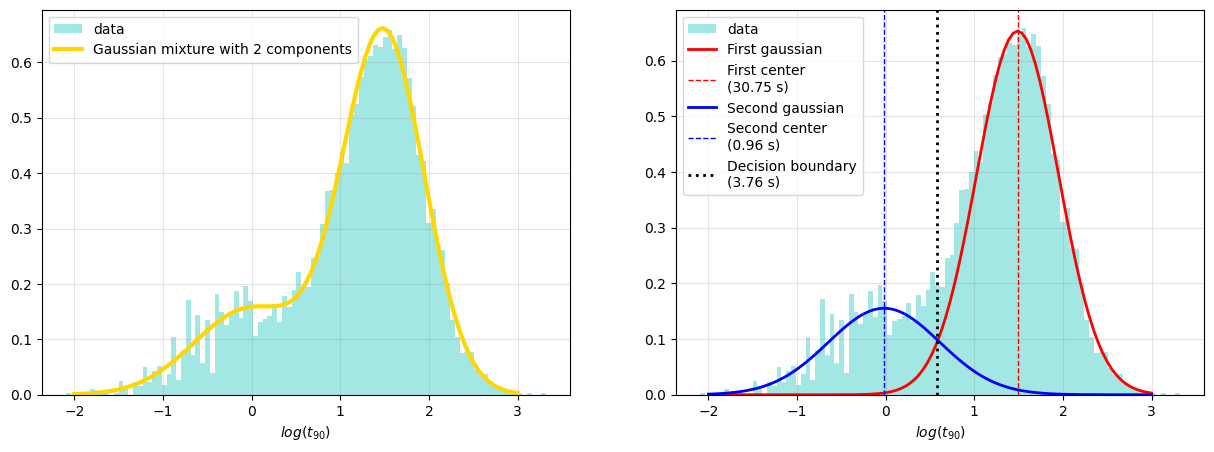

In [11]:
xgrid=np.linspace(-2, 3, 100)

# Plotting the Gaussian mixture model
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].hist(logt90, bins=100, density=True, color='mediumturquoise', alpha=0.5, label = 'data')
ax[0].plot(xgrid, np.exp(best_model.score_samples(xgrid[:, np.newaxis])), c='gold', lw= 3, label = 'Gaussian mixture with 2 components')
ax[0].grid(c='grey', alpha = 0.2)
ax[0].set_xlabel('$log(t_{90})$')
ax[0].legend(loc='upper left')

# Plotting the single gaussians
contr = best_model.predict_proba(xgrid[:, np.newaxis])
pdf_contr = contr*np.exp(best_model.score_samples(xgrid[:, np.newaxis]))[:, np.newaxis]
means = best_model.means_.flatten()
decision_boundary = xgrid[np.argmin(np.abs(contr[:, 0] - contr[:, 1]))]

ax[1].hist(logt90, bins=100, density=True, color='mediumturquoise', alpha = 0.5, label = 'data')
ax[1].plot(xgrid, pdf_contr[:, 0], c='red', lw= 2, label = 'First gaussian')
ax[1].axvline(means[0], c='red', lw = 1, ls = '--', label = 'First center\n(%.2f s)' % 10**means[0])
ax[1].plot(xgrid, pdf_contr[:, 1], c='blue', lw= 2, label = 'Second gaussian')
ax[1].axvline(means[1], c='blue', lw = 1, ls = '--', label = 'Second center\n(%.2f s)' % 10**means[1])
ax[1].axvline(decision_boundary, c='black', lw = 2, ls = ':', label = 'Decision boundary\n(%.2f s)' % 10**decision_boundary)
ax[1].grid(c='grey', alpha = 0.2)
ax[1].set_xlabel('$log(t_{90})$')
ax[1].legend(loc='upper left')
plt.show()

We can now be fairly confident about the bimodality of the data.

Given what we know now, we can use k-means clustering:

### K-Means clustering

In [20]:
scaler = preprocessing.StandardScaler()
scaled_logt90 = scaler.fit_transform(logt90[:, np.newaxis])

In [32]:
km = KMeans(n_clusters=2)
km.fit(scaled_logt90)

scaled_centers_km = km.cluster_centers_
labels_km = km.predict(scaled_logt90)

if scaled_centers_km[0] > scaled_centers_km[1]:
    scaled_centers_km = scaled_centers_km[::-1]
    labels_km = np.array(~np.array(labels_km, dtype='bool'), dtype='int')

centers_km = scaler.inverse_transform(scaled_centers_km)

edge_km = np.mean([max(logt90[labels_km==0]), min(logt90[labels_km==1])])

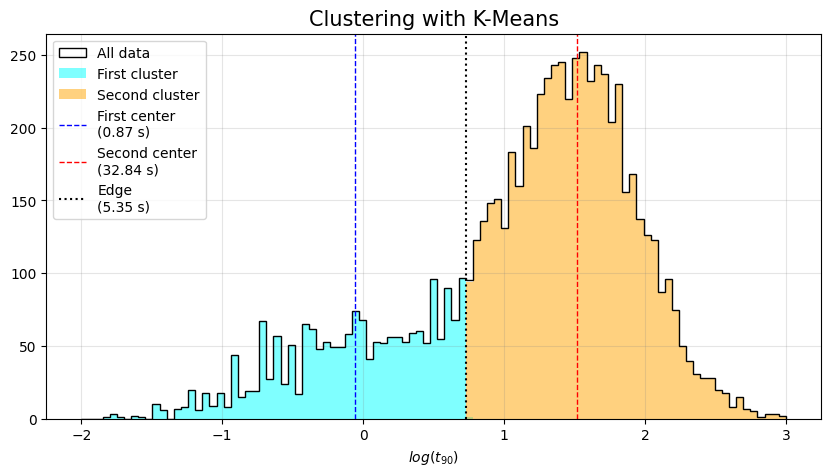

In [33]:
plt.figure(figsize=(10, 5))
plt.hist(logt90, bins=np.linspace(-2, 3, 100), color='black', histtype = 'step', linewidth=1, label = 'All data')
plt.hist(logt90[labels_km==0], bins=np.linspace(-2, 3, 100), color='cyan', alpha = 0.5, label = 'First cluster')
plt.hist(logt90[labels_km==1], bins=np.linspace(-2, 3, 100), color='orange', alpha = 0.5, label = 'Second cluster') 
plt.axvline(centers_km[0], c = 'blue', lw = 1, ls = '--', label = 'First center\n(%.2f s)' % 10**centers_km[0][0])
plt.axvline(centers_km[1], c = 'red', lw = 1, ls = '--', label = 'Second center\n(%.2f s)' % 10**centers_km[1][0])
plt.axvline(edge_km, c = 'black', lw = 1.5, ls = ':', label = 'Edge\n(%.2f s)' % 10**edge_km)
plt.grid(c='grey', alpha = 0.2)
plt.xlabel('$log(t_{90})$')
plt.title('Clustering with K-Means', fontsize = 15)
plt.legend(loc='upper left')
plt.show()